C:\Users\JAKUBZ~1\AppData\Local\Temp/ipykernel_21632/2886259470.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


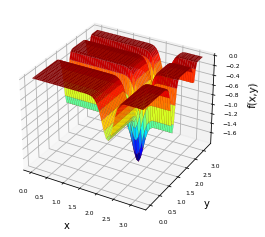

In [1]:
# michalewicz_graph.py

from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(0, 3.2, 50)    
Y = np.linspace(0, 3.2, 50)    
X, Y = np.meshgrid(X, Y)

# Michalewicz function
Z = -1 * ( (np.sin(X) * np.sin((1 * X**2) / np.pi)**20) + \
           (np.sin(Y) * np.sin((2 * Y**2) / np.pi)**20) )

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, \
  rstride=1, cstride=1, cmap=cm.jet, \
  edgecolor='darkred', linewidth=0.1)

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)
ax.set_zlabel('f(x,y)', fontsize=10)
ax.tick_params(axis='both', which='major',
  labelsize=6)
    
plt.show()

Nelder Mead Function

In [2]:
def f(v): 
   return -1 * ( (np.sin(v[0]) * np.sin((1 * v[0]**2) / np.pi)**20) + \
            (np.sin(v[1]) * np.sin((2 * v[1]**2) / np.pi)**20) )
    

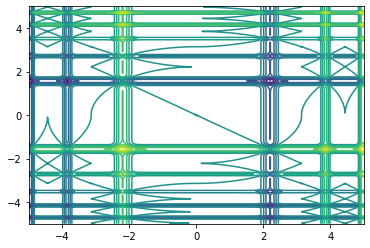

In [3]:
X, Y = np.meshgrid(np.linspace(-5, 5, 2000),
                   np.linspace(-5, 5, 2000))

Z = f([X,Y])

plt.contour(X, Y, Z, levels = 20)
plt.show()

In [4]:
def i_trg(x, y, c):
    x1 = x + c
    y1 = y
    x2 = x + c/2
    y2 = y + (c/2)*(3**(1/2))
    return list(zip(np.array([x,x1,x2]), np.array([y,y1,y2])))

In [5]:
def BGW(V, f):
    T = [(V[i], f(V[i])) for i in range(len(V)) ]
    return sorted(T, key=itemgetter(1))

    # alternatively, equivalent:
    #return sorted(T, key=lambda column: column[1]) 

In [6]:
def midpoint(o_trg, A=0, B=1):
    return ((o_trg[A][0][0] + o_trg[B][0][0])/2,
            (o_trg[A][0][1] + o_trg[B][0][1])/2)

def reflection(o_trg):
    M = midpoint(o_trg)
    W = o_trg[2][0]
    return (2*M[0] - W[0], 2*M[1] - W[1])

def expansion(o_trg):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    return (2*R[0] - M[0], 2*R[1] - M[1])

def contraction(o_trg, f):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    W = o_trg[2][0]
    insC = ((W[0] + M[0])/2, (W[1] + M[1])/2)
    outC = ((R[0] + M[0])/2, (R[1] + M[1])/2)
    return (insC, outC)

def shrink(o_trg, f):
    M, S  = midpoint(o_trg), midpoint(o_trg, A=0, B=2)
    return M, S

In [7]:
def nelder_mead(o_trg, f, iterations, plot=False):
    print("k \t {:^20}   \t {:^20}   \t {:^20}".format("Best point", "Good point", "Worst point"))
     
    for i in range(iterations):
        
        if (i == 0):     
            print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
                    .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                            o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                            o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))

            if plot:
                bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
                plt.clf()
                plt.contour(X, Y, Z, levels = 50)
                plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
                plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
                plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
                plt.plot(bgw[0,0], bgw[0,1], '.r')
                plt.show(block=False)
                plt.pause(0.1)
        
        
        R = reflection(o_trg)
        G = o_trg[1][0]
        B = o_trg[0][0]
        
        if f(R) < f(G):
            # Case 1: reflection found a better point than Good point

            if f(B) < f(R):
                # Case 1a: reflected point is not better than Best point -> replace Worst with R and end this iteration
                
                o_trg = BGW([B, G, R], f)              
            else:
                # Case 1b: reflected point is better than Best point -> go even further (expansion)
                
                E = expansion(o_trg)
                if f(E) < f(R):
                    # Case 1ba: expanded point is better than reflected point -> replace Worst with E and end this iteration
                    o_trg = BGW([B, G, E], f)
                else:
                    # Case 1bb: expanded point is not better than reflected point -> replace Worst with R and end this iteration
                    o_trg = BGW([B, G, R], f)
        else:
            # Case 2: reflection found a worse point than Good point

            W = o_trg[2][0]
            if f(R) > f(W):
                # Case 2a: reflected point is worse than Worst point -> perform inside contraction
                C = contraction(o_trg, f)[0]
            else:
                # Case 2b: reflected point is not worse than Worst point -> perform outside contraction
                C = contraction(o_trg, f)[1]

            if f(C) < f(W):
                # Case 3a: contraction worked -> replace Worst with C and end this iteration
                o_trg = BGW([B, G, C], f)
            else:
                # Case 3b: contraction did not work -> shrink the triangle
                M, S = shrink(o_trg, f)
                o_trg = BGW([B, M, S], f)
         
        print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
              .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                      o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                      o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))
        
        if plot:
            bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
            plt.clf()
            plt.contour(X, Y, Z, levels = 50)
            plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
            plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
            plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
            plt.plot(bgw[0,0], bgw[0,1], '.r')
            plt.show(block=False)
            plt.pause(0.1)
            
    plt.show()
                
    return o_trg

In [8]:
X, Y = np.meshgrid(np.linspace(-5, 5, 2000),
                   np.linspace(-5, 5, 2000))
v_func = np.vectorize(f)
Z = f([X,Y])

In [9]:
trg = i_trg(2,3.5,1)
trg

[(2.0, 3.5), (3.0, 3.5), (2.5, 4.366025403784438)]

In [11]:
nelder_mead(o_trg,f,20,plot=True)

k 	      Best point        	      Good point        	     Worst point     


TypeError: 'function' object is not subscriptable

MovieWriter imagemagick unavailable; using Pillow instead.


PSO found best solution at f([2.203394   1.57107644])=-1.8012963529610748
Global optimal at f([2.2222222222222223, 1.5656565656565655])=-1.794144469027823


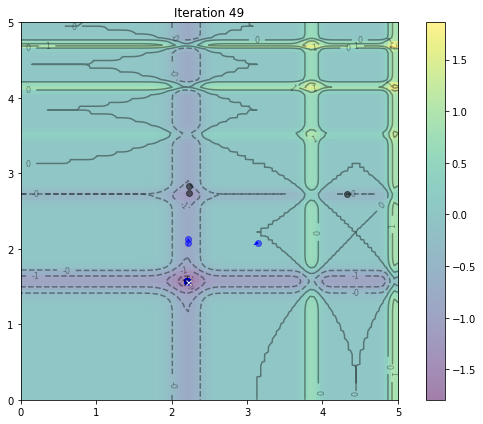

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
 
def f(x,y):
    "Objective function"
    return -1 * ( (np.sin(x) * np.sin((1 * x**2) / np.pi)**20) + \
           (np.sin(y) * np.sin((2 * y**2) / np.pi)**20) )
    
# Compute and plot the function in 3D within [0,5]x[0,5]
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = f(x, y)
 
# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
 
# Hyper-parameter of the algorithm
c1 = c2 = 0.1
w = 0.8
 
# Create particles
n_particles = 20
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1
 
# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()
 
def update():
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj = f(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()
 
# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([0,5])
ax.set_ylim([0,5])
 
def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    # Update params
    update()
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot
 
anim = FuncAnimation(fig, animate, frames=list(range(1,50)), interval=500, blit=False, repeat=True)
anim.save("PSO.gif", dpi=120, writer="imagemagick")
 
print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], f(x_min,y_min)))